
# Section 1: Business Understanding - Credit Card Fraud Detection
How to detect credit card fraud by Machine Learning algorithms?

Author: Wen Yue

Date: 18/03/2021

The credit card transaction records are fake data from Kaggle: https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv. 

Each row of transaction record includes a lot of features of the transaction inforamtion and label 'is_fraud'.
The project aim is to develop a model to predict the new transaction is fraud or not with some features of the transaction known. 

The evaluation of DNN model on test data: precision is 79%, recall is 53%, f1 score is 64%.
The evaluation of Random Forest on test data: precision is 73%, recall is 65%, f1-score is 68%.

- Precision means the ratio of correctly predicted positive (is fraud) to the total predicted positive.
- Recall means the ratio of correctly predicted positive (is fraud) to all positive observations.
- f-1 score is the balance of the precision and recall.

The following sections will be:
- Data Understsanding
- Data Preparation
- Modelling and Prediction - Deep Neural Network 
- Alternative Modelling and Prediction - Random Forest

# Section 2 : Data Understanding

## 2.1 - import data of credit card fraud 

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### two data sources: train and test, combine them together firstly and split them randomly when modelling
### import train data from csv
df_tr = pd.read_csv('../fraudTrain.csv')
df_tr = df_tr.iloc[:,1:] # the first row is just row order

### import test data
df_test = pd.read_csv('../fraudTest.csv')
df_test = df_test.iloc[:,1:]

### combine the train dataset and test dataset
df = pd.concat([df_tr,df_test],axis = 0)

## 2.2 - Exploration of the features and label
###  data overview

In [28]:
### Data overview 
print(df.describe().transpose()) # the numerical feature statistical summary; 
print(df.info(null_counts= True)) # all of the features information; 
print(df.nunique()) # all of unique values of different features

                count          mean           std           min           25%  \
cc_num      1852394.0  4.173860e+17  1.309115e+18  6.041621e+10  1.800429e+14   
amt         1852394.0  7.006357e+01  1.592540e+02  1.000000e+00  9.640000e+00   
zip         1852394.0  4.881326e+04  2.688185e+04  1.257000e+03  2.623700e+04   
lat         1852394.0  3.853931e+01  5.071470e+00  2.002710e+01  3.466890e+01   
long        1852394.0 -9.022783e+01  1.374789e+01 -1.656723e+02 -9.679800e+01   
city_pop    1852394.0  8.864367e+04  3.014876e+05  2.300000e+01  7.410000e+02   
unix_time   1852394.0  1.358674e+09  1.819508e+07  1.325376e+09  1.343017e+09   
merch_lat   1852394.0  3.853898e+01  5.105604e+00  1.902742e+01  3.474012e+01   
merch_long  1852394.0 -9.022794e+01  1.375969e+01 -1.666716e+02 -9.689944e+01   
is_fraud    1852394.0  5.210015e-03  7.199217e-02  0.000000e+00  0.000000e+00   

                     50%           75%           max  
cc_num      3.521417e+15  4.642255e+15  4.992346e+18 

### Correlation of all the data 
- there is much more no fraud records than fraud records
- 'amt' is the largest correlated feature with data labelm

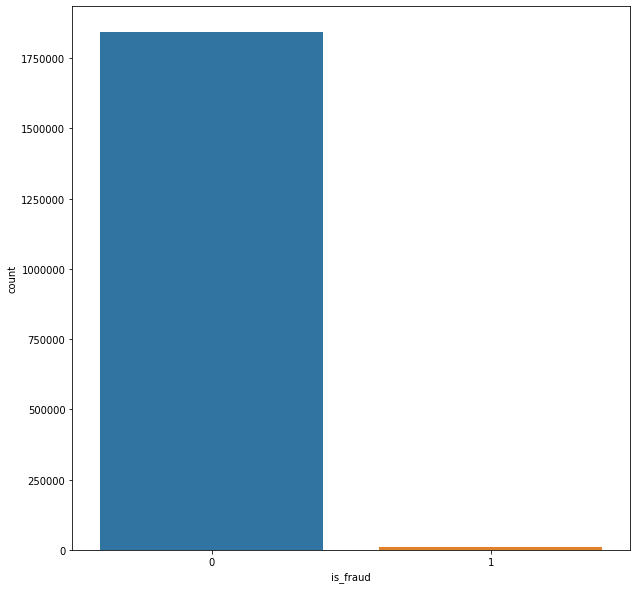

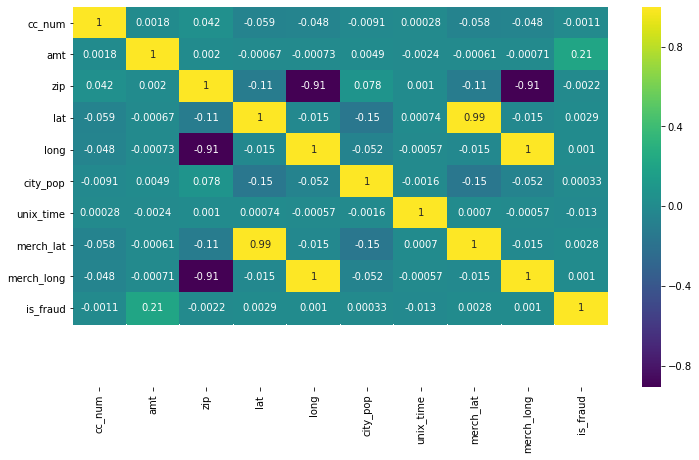

In [29]:
### Exploration of the features and label
plt.figure(figsize = (10,10))
sns.countplot(x ='is_fraud',data = df)
plt.show()

### visualization of the correlation
plt.figure(figsize = (12,7))
sns.heatmap(df.corr(),annot = True, cmap = 'viridis')
plt.ylim(12, 0)
plt.show()

### Different fraud percentage in different groups
- 100% transcation in state DE is fraud
- top 3 high percentage fraud categories are shopping net, misc_net, grocery_pos
- more female transaction records than male in the data

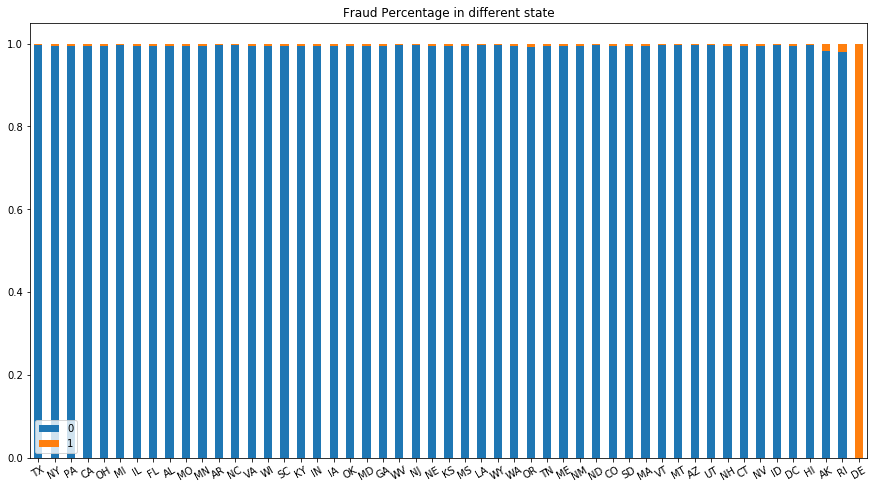

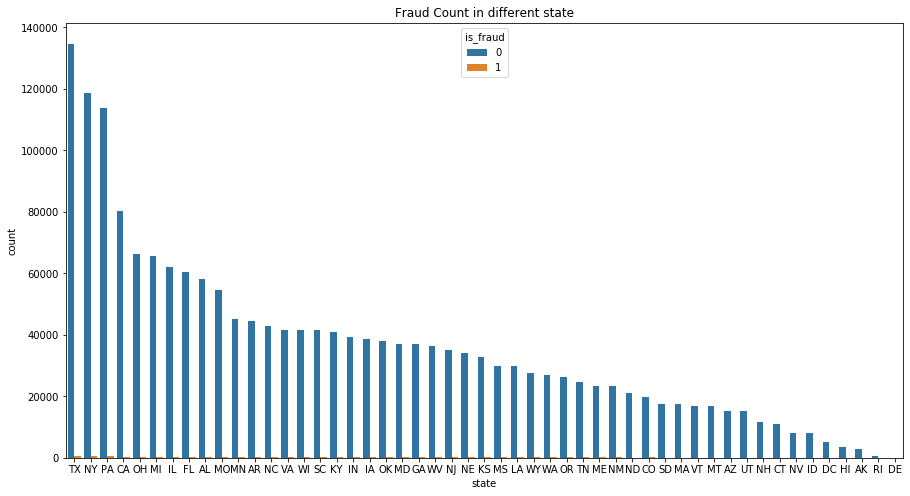

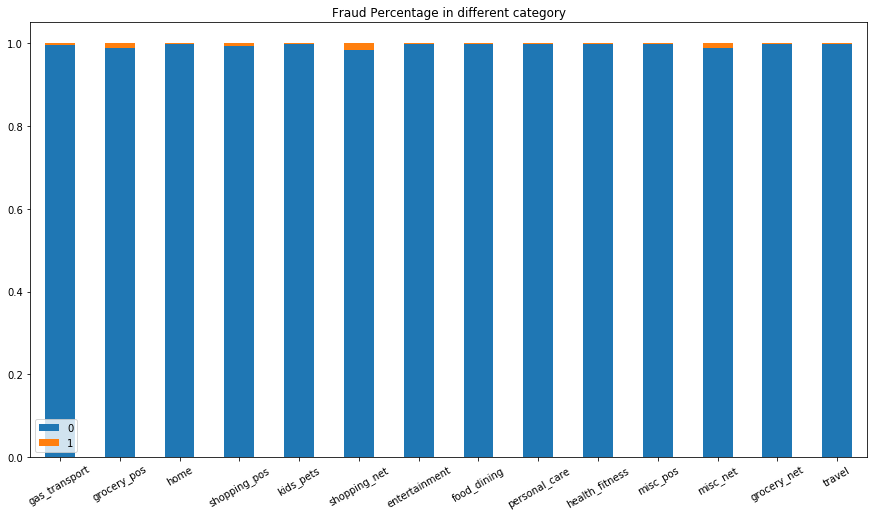

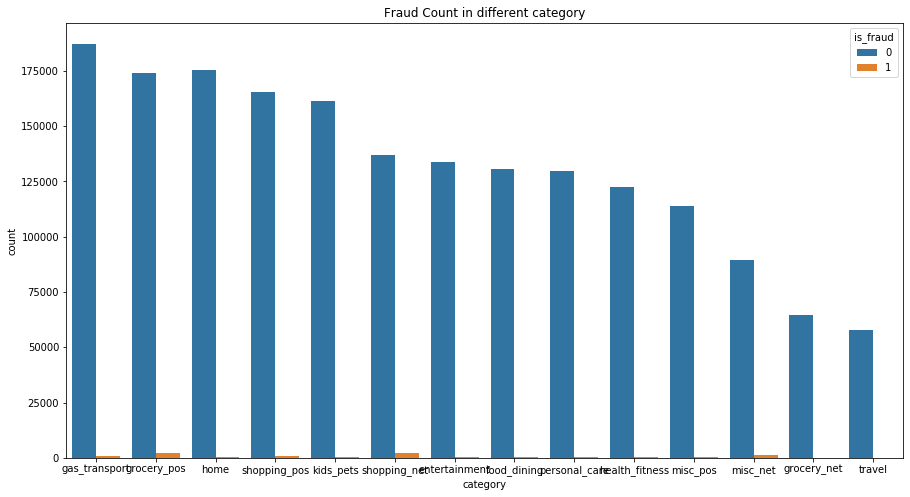

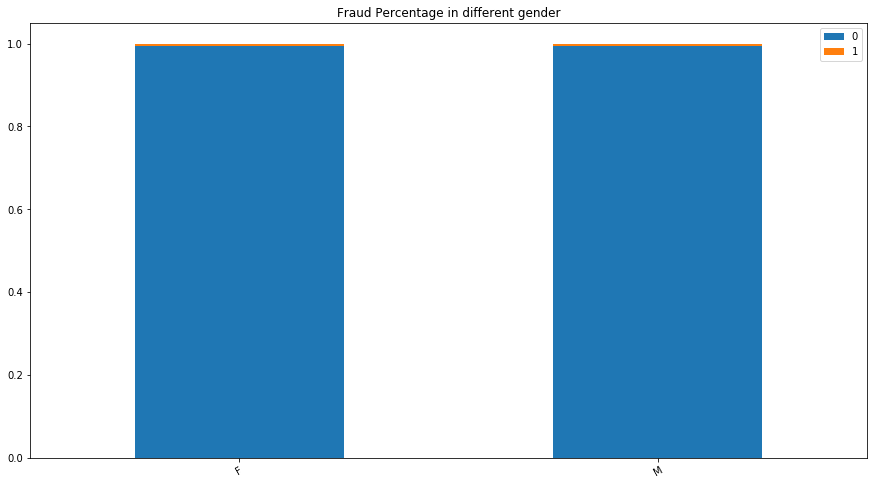

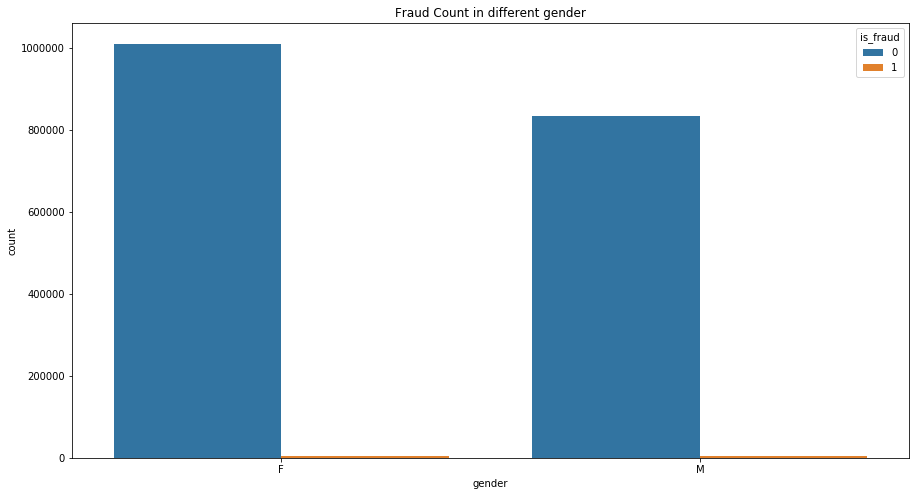

In [30]:
### different feature, fraud percentage:
### the top 3 high percentage is shopping net, misc_net, grocery_pos
def plot_FraudPer_byF(feature):
    feature_per = pd.DataFrame()
    for feature_i in list(df[feature].value_counts().index):
        feature_iper = df[df[feature] == feature_i].groupby('is_fraud').count()['cc_num']/df[df[feature] == feature_i].shape[0]
        feature_iper.rename(feature_i, inplace = True) 
        feature_per = pd.concat([feature_per, feature_iper], axis = 1) 
    feature_per.transpose().plot(kind = 'bar', stacked=True, figsize = (15,8))
    plt.title('Fraud Percentage in different {}'.format(feature))
    plt.xticks(rotation = 30)
    plt.show()
    
### count fraud with different values of one feature
def plot_Fraud_byF(feature):
    plt.figure(figsize=(15,8))
    feature_order = df[feature].value_counts().index
    sns.countplot(x = feature, data = df, order = feature_order, hue = 'is_fraud')
    plt.title('Fraud Count in different {}'.format(feature))
    plt.show()

### examples to plot the fraud count/percentage by features values

feature = 'state'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

feature = 'category'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

feature = 'gender'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

### order by fraud percentage tables
#feature_per.transpose().sort_values(by =1, ascending = False)

## Section 3: Data Preparation

### 3.1 Feature engineering
- select the likely features 
- reduce the categories of some features, like job
- drop some features like merchant (due to model overfitting with it) 
- transfer the object feature type to dummy variables


In [6]:
### amount shows the highest correlation with data label 'is_fraud'
### drop some features with least possibility like first name, last name and longtitue, latitude
### 693 merchants was included in the first time modelling but overfitting with it, so drop it
df = df[['amt','category','state','gender','job','is_fraud']]

### reduce the unique job counts by the following criteria:
### all jobs with appearance amount <1000, put in 'other'
low_count_job = df.job.value_counts()[df.job.value_counts().values < 1000].index
df.loc[df.job.isin(low_count_job), ['job']] = 'other'

###### transfer 14 category, 2 genders, 51 state and 418 job names to dummy variables
dummies = pd.get_dummies(df[['category', 'gender','state','job']],drop_first=True)
df = df.drop(['category', 'gender','state', 'job'],axis=1)
df = pd.concat([df,dummies],axis = 1)

# Section 4: Data Modelling - Neural Network
## 4.1- split to train and test randomly
- set X and y for feature and lable
- split to train and test
- Normalise the data

In [7]:
### Modelling
### Set X and y variables to the features and label
X = df.drop('is_fraud', axis =1).values
y = df['is_fraud'].values

from sklearn.model_selection import train_test_split
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4.2 - Neural network model with Keras API
- import libraries
- sequential model with dense layers, drop out, activation function, early stop etc.
- regularizer set zero, since l2 regularizer did not give better result

### Import tensorflow libraries

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

### Sequential models with specific dense layers, drop out, activation functions etc through trial and test.

In [9]:
model = Sequential()
factor = 0
# input layer
model.add(Dense(500,  kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(250, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(120, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(60, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(30, kernel_regularizer=l2(factor),activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks= [early_stop]
          )

from tensorflow.keras.models import load_model
model.save('Fraud_Detect_ANN_model_final.h5') 

Train on 1296675 samples, validate on 555719 samples
Epoch 1/25
1296675/1296675 [==============================] - 51s 39us/sample - loss: 0.0321 - val_loss: 0.0233
Epoch 2/25
1296675/1296675 [==============================] - 52s 40us/sample - loss: 0.0230 - val_loss: 0.0198
Epoch 3/25
1296675/1296675 [==============================] - 52s 40us/sample - loss: 0.0201 - val_loss: 0.0203
Epoch 4/25
1296675/1296675 [==============================] - 51s 40us/sample - loss: 0.0183 - val_loss: 0.0171
Epoch 5/25
1296675/1296675 [==============================] - 51s 39us/sample - loss: 0.0167 - val_loss: 0.0161
Epoch 6/25
1296675/1296675 [==============================] - 51s 40us/sample - loss: 0.0156 - val_loss: 0.0154
Epoch 7/25
1296675/1296675 [==============================] - 54s 42us/sample - loss: 0.0149 - val_loss: 0.0148
Epoch 8/25
1296675/1296675 [==============================] - 52s 40us/sample - loss: 0.0142 - val_loss: 0.0148
Epoch 9/25
1296675/1296675 [=======================

### plotting losses of train and test data with binary cross entropy as loss functions

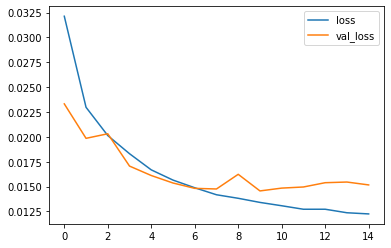

In [10]:
### losses function of train and test data, very low loss and no overfitting
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

### Fraud Detection Neural Network Model Evaluation
- Precision is 0.79, i.e. the ratio of correctly predicted positive (is fraud) to the total predicted positive is 79%.  
- Recall is 0.53, i.e. the ratio of correctly predicted positive (is fraud) to all positive observations is 53%. 
- f1-score is 0.64, is the balance of Precision and Recall. 

- Formulas:
    - Precison = True Positive/(True Positive + False Positive) 
    - Recall = True Positive/(True Positive + False Negative)
    - f1-score =  2*((Precision * Recall)/(Precision + Recall))
- Confusion matrix: 
                     True Positive  False Negative
                     False Positive True Negative

In [16]:
### Classification report and confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))
print('Confusion matrix is as below:\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552842
           1       0.79      0.53      0.64      2877

    accuracy                           1.00    555719
   macro avg       0.89      0.77      0.82    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix is as below:

[[552431    411]
 [  1347   1530]]


## Section 5: Alternative Way: Data Modelling - Random Forest

In [17]:
### split the data to train and test
from sklearn.model_selection import train_test_split
X = df.drop('is_fraud',axis=1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [18]:
### call random forest model to fit and predict
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators  = 300)

rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552842
           1       0.73      0.65      0.68      2877

    accuracy                           1.00    555719
   macro avg       0.86      0.82      0.84    555719
weighted avg       1.00      1.00      1.00    555719

[[552146    696]
 [  1020   1857]]


### Any other possible ways to detect fraud:
- Anomaly detection by Gaussion distribution...
- Autoencoders in Keras